In [9]:
import DeconV as dv
import scout

import glob, tqdm, time, os

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import scanpy as sc
import torch

import tqdm
import scout

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
reference_file = "../../data/pbmc/reference.h5ad"
bulk_file = "../../data/pbmc/bulk.txt"
cell_types = [
    'CD4 T', 'Monocytes',
    'B cells', 'CD8 T',
    'NK', 'Monocytes',
    'DCs']

In [11]:
adata = sc.read_h5ad(reference_file)
adata.X = adata.X.astype("float32").toarray()


adata = adata[adata.obs["labels"].astype("str").isin(cell_types), :].copy()

print(adata.obs.groupby("labels").size())

bulk_df = pd.read_table(bulk_file, index_col=0)

print(f"bulk RNA-seq data - samples: {bulk_df.shape[0]}, genes: {bulk_df.shape[1]}")

# bulk_df *= 1e6

sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata = dv.tl.combine(adata, bulk_df)
scout.tl.scale_log_center(adata, target_sum=None, exclude_highly_expressed=False)
# sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=True)
adata.shape

labels
B cells       343
CD4 T        1304
CD8 T         152
DCs            35
Monocytes     635
NK            153
dtype: int64
bulk RNA-seq data - samples: 13404, genes: 12
scRNA-seq data - cells: 2622, genes: 13293
bulk RNA-seq data - samples: 12, genes: 13293


(2622, 13293)

In [12]:
sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white')
sc.settings.figdir = "../deconV/figures/"

In [13]:
sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

/home/lutrarutra/.pyenv/versions/3.10.9/envs/lst/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


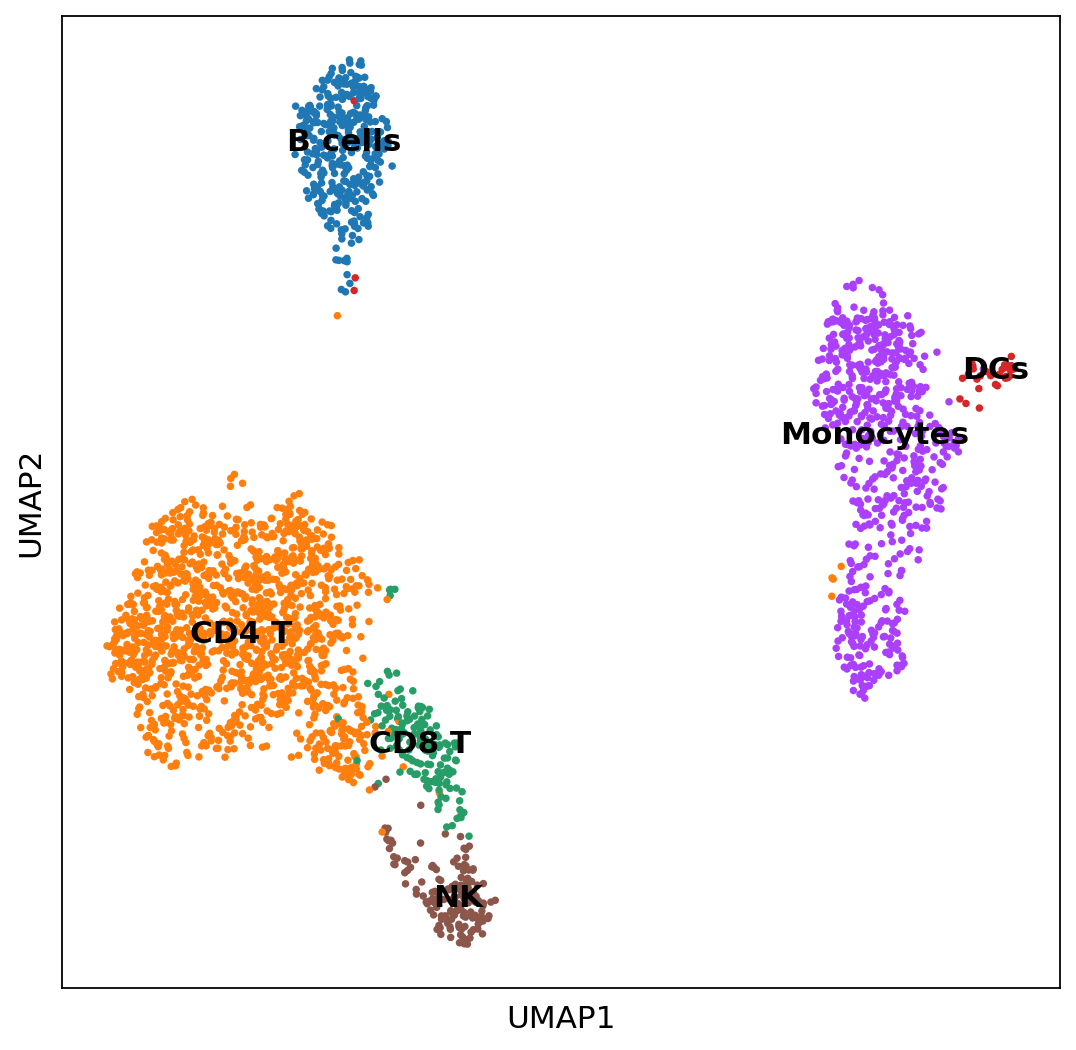

In [14]:
sc.pl.umap(adata, color=["labels"], frameon=True, legend_loc="on data", title="")

## GPU Acceleration

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Define Model and Fit Reference

In [16]:
decon = dv.DeconV(
    adata, cell_type_key="labels",  # cell_type_key is the column key in adata.obs that holds the cell type annotations 
    dropout_type="separate",        # separate, shared, or None
    model_type="nb",             # Gamma, Beta, nb, lognormal, or static    
    device=device
)

In [17]:
decon.fit_reference(num_epochs=2000, lr=0.1, lrd=0.999, layer="counts", fp_hack=False)

100%|██████████| 2000/2000 [02:49<00:00, 11.82it/s, loss=2.86e+03, lr=1.35e-02]


## (Optional): Asses fit of the model

In [18]:
# decon.check_fit()

## Deconvolute

In [19]:
proportions = decon.deconvolute(model_dropout=True, lrd=0.999, lr=0.1, num_epochs=1000)

100%|██████████| 1000/1000 [00:14<00:00, 69.70it/s, loss=3.59e+07, lr=3.68e-02]


## Comparison to Ground Truth

In [20]:
true_df = pd.read_csv("../../data/pbmc/true.csv", sep=",", index_col=0)
true_df = true_df.reindex(sorted(true_df.columns), axis=1)

In [21]:
true_melt = true_df.reset_index().melt(id_vars="sample").rename(columns={"value":"true", "variable":"cell_type"})
res_melt = decon.get_results_df()

In [22]:
assert (true_melt["sample"] == res_melt["sample"]).all()
assert (true_melt["cell_type"] == res_melt["cell_type"]).all()
res_melt["true"] = true_melt["true"].values

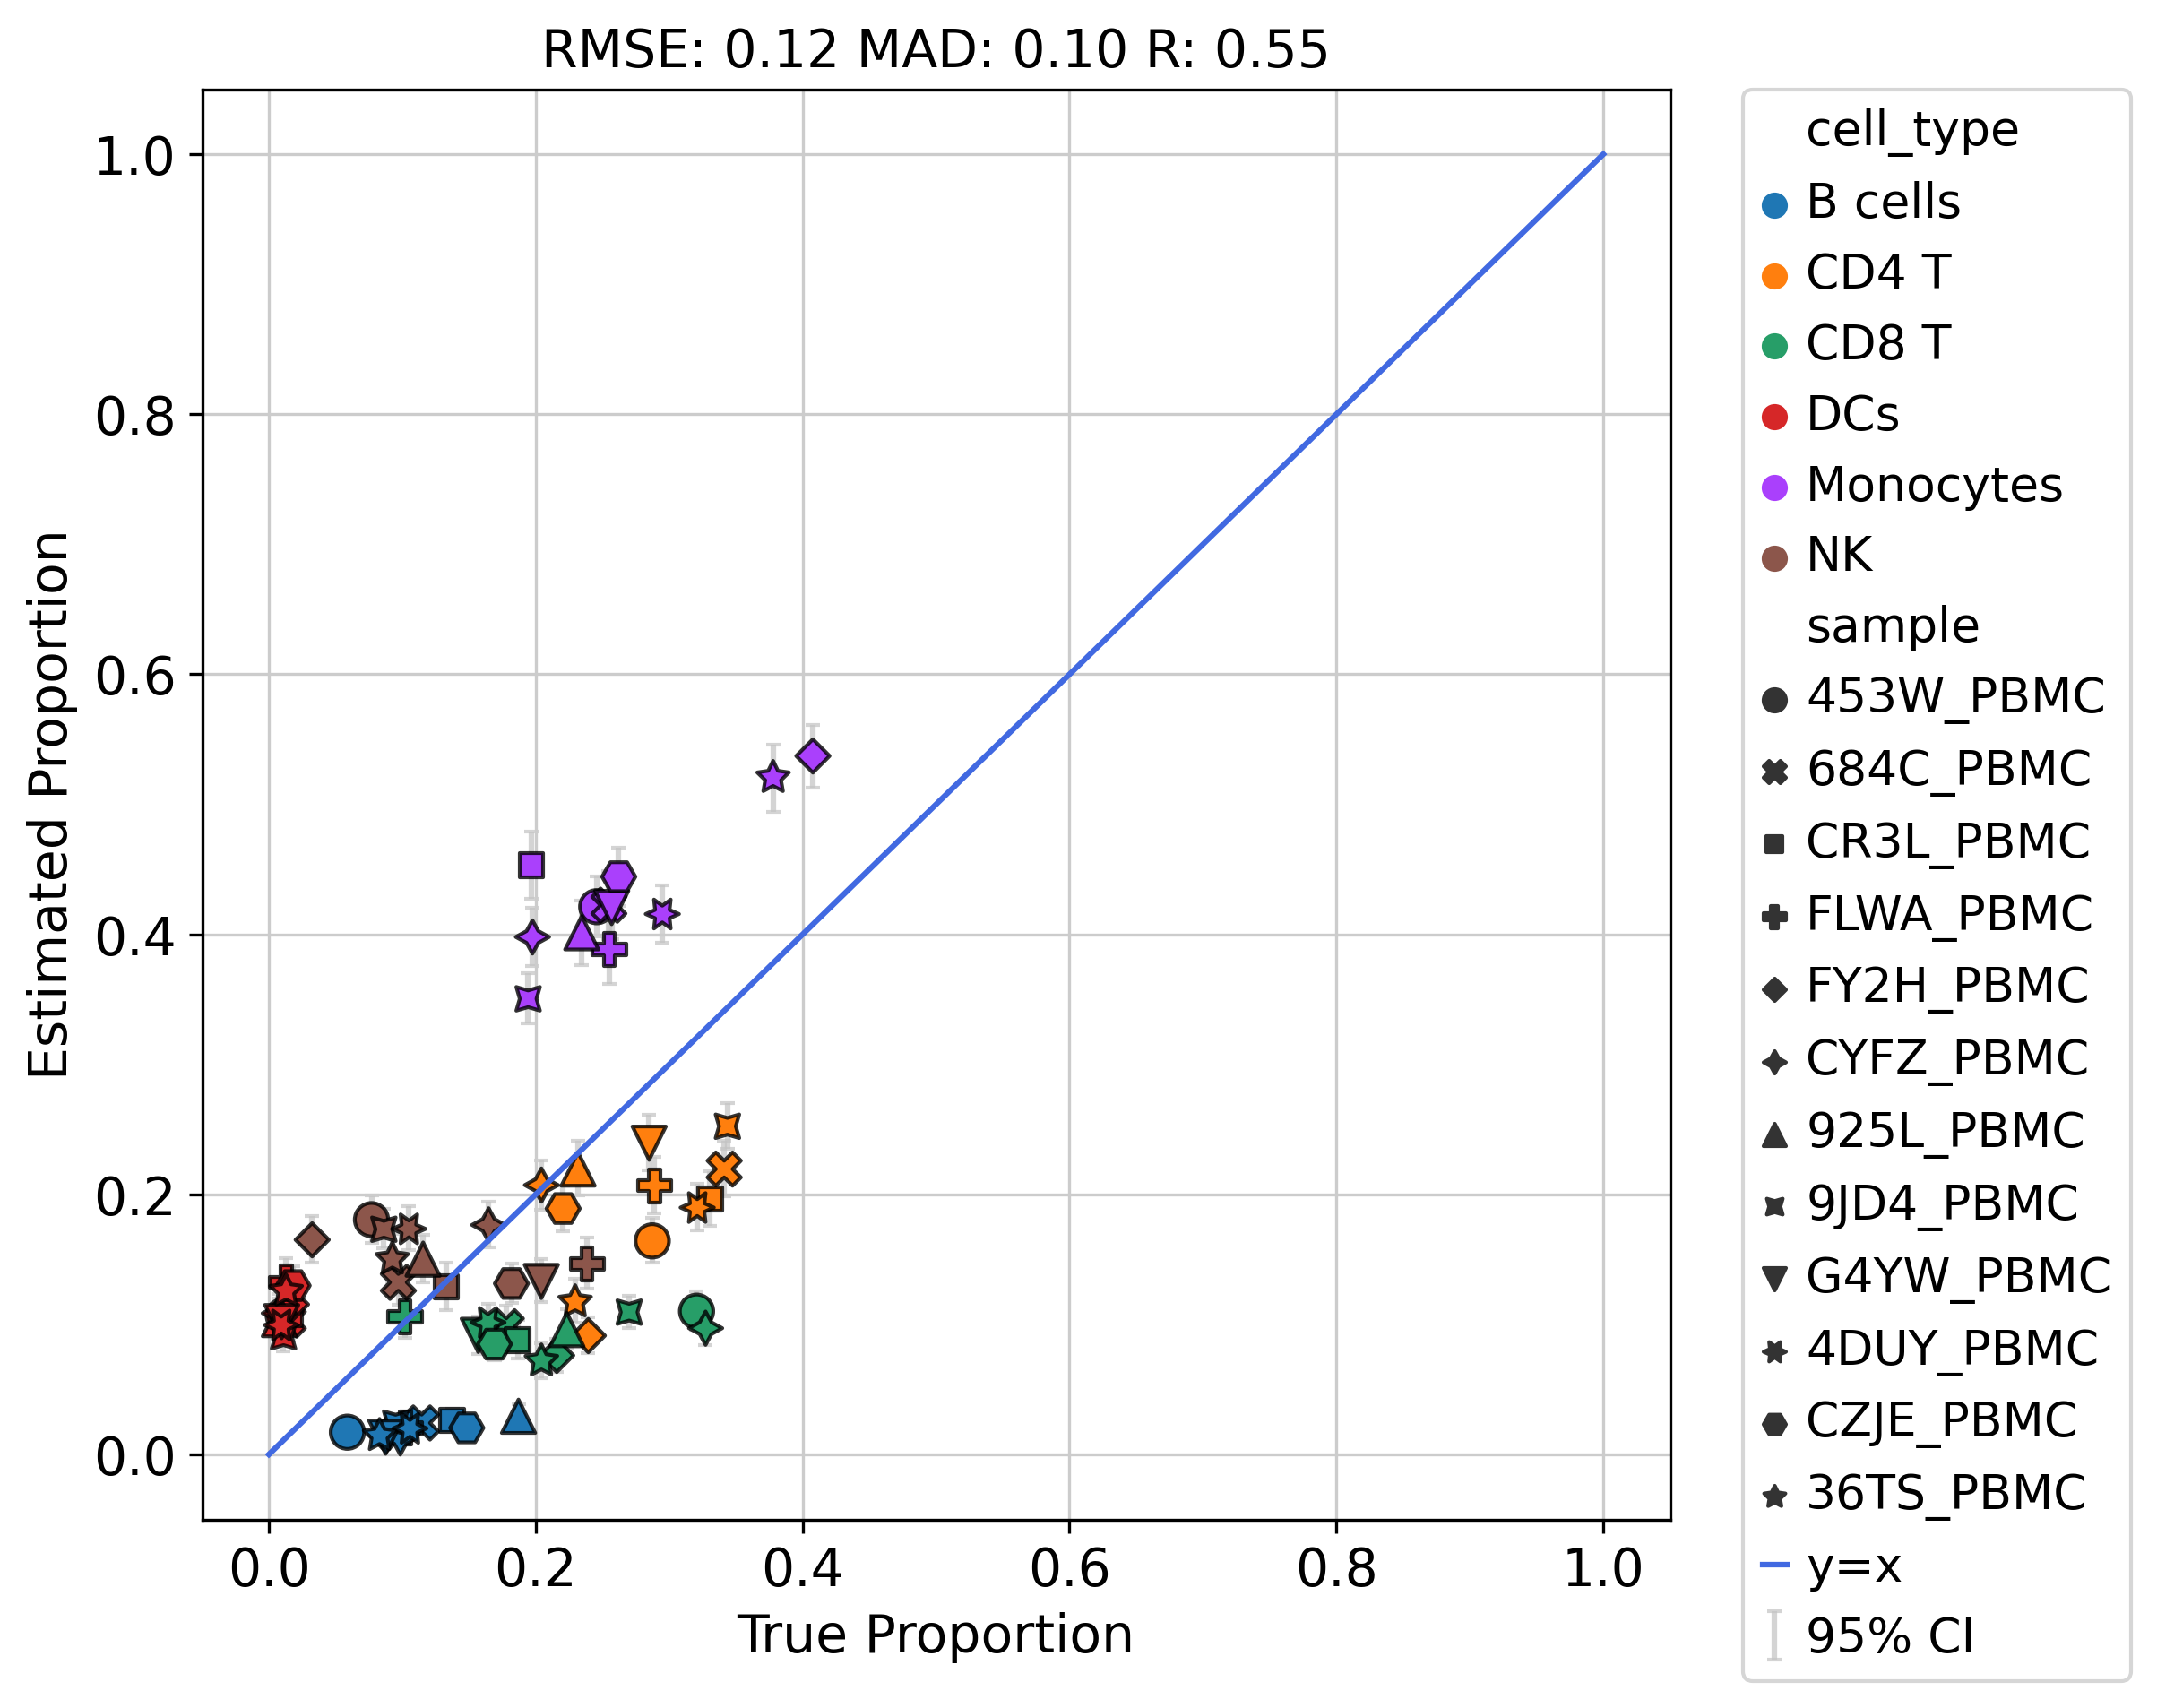

(0.11529735899070087, 0.1030652531352381, 0.5535807632702786)

In [23]:
dv.pl.xypredictions(res_melt, figsize=(7,7), dpi=150)#, path=f"../benchmarks/figures/pbmc/{decon.model_type}.png")

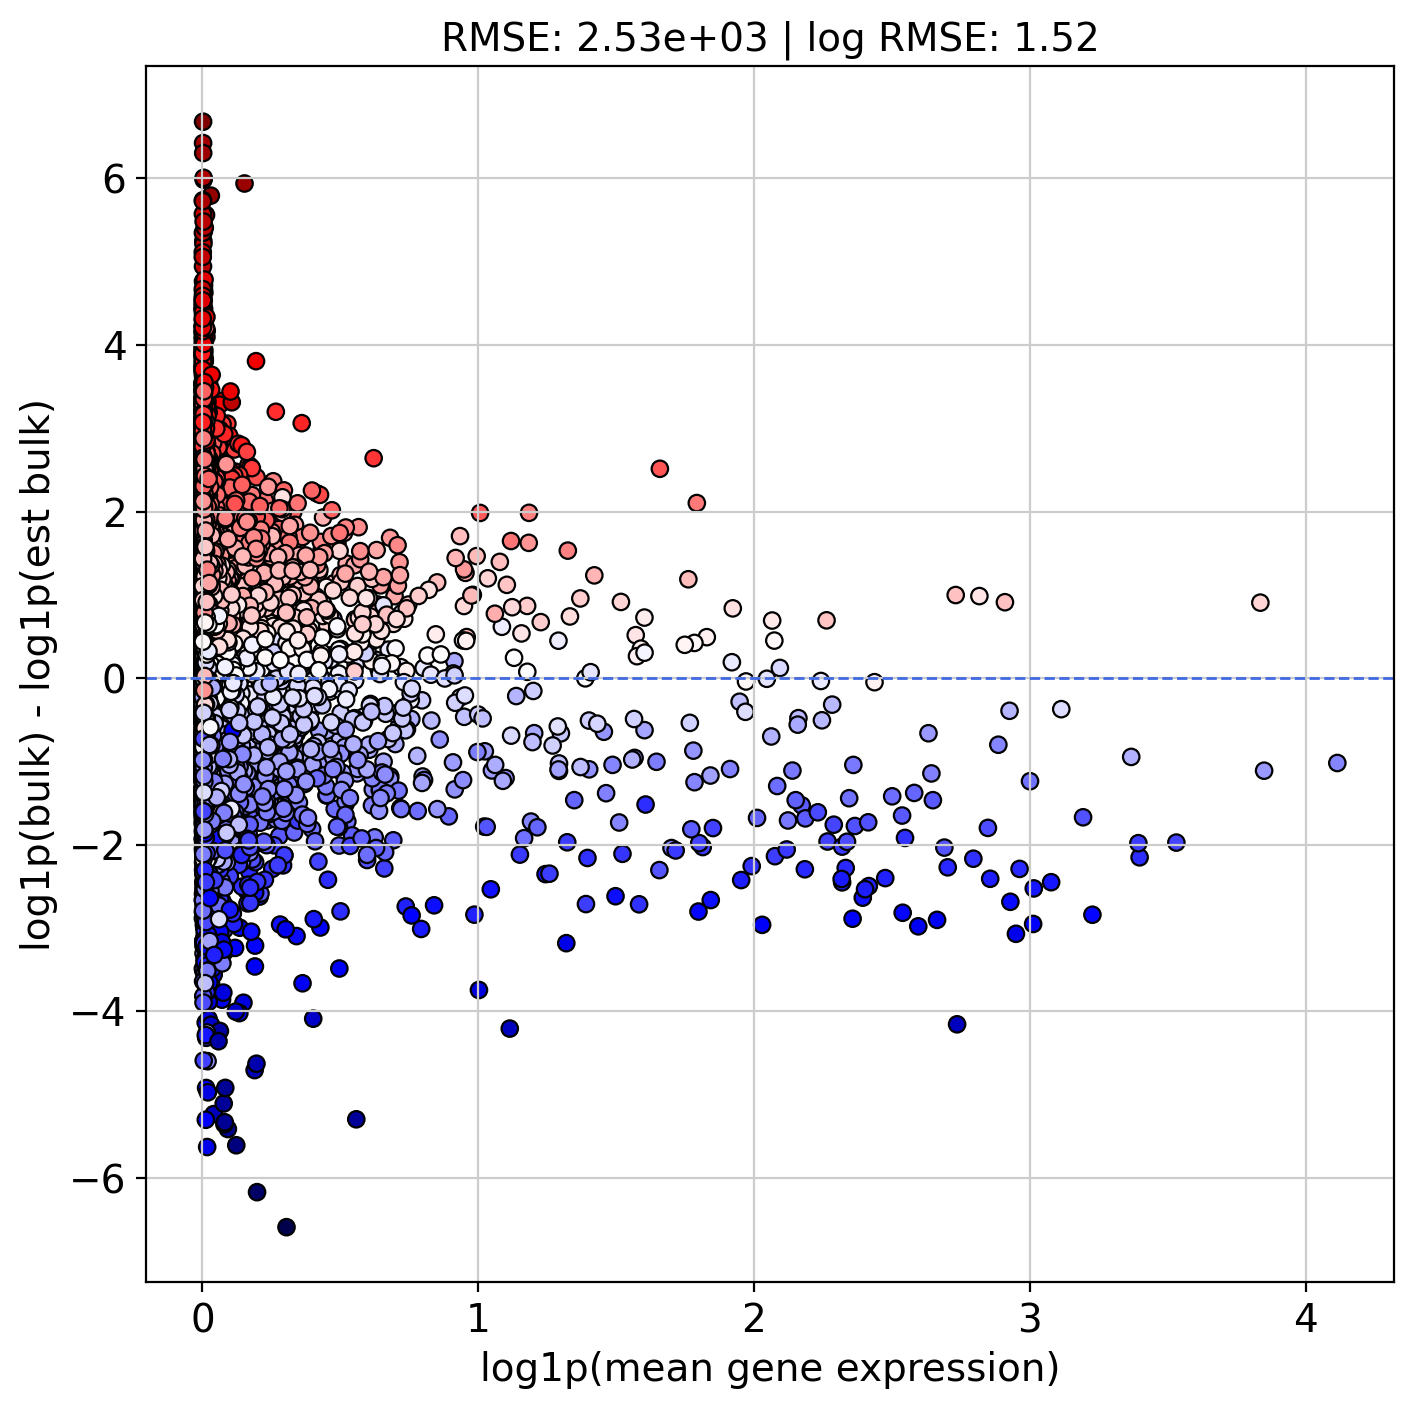

In [24]:
dv.pl.prediction_plot(decon, 0)